File loaded
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752

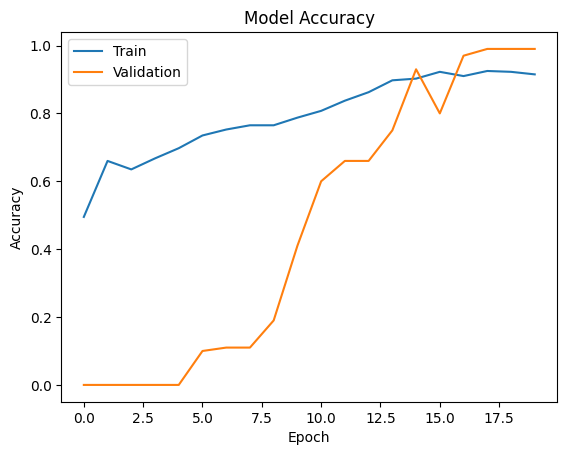

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GRU, Dense, Input, GlobalAveragePooling2D, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define paths to the folders
real_videos_path = "test-real250"
deepfake_videos_path = 'test-fake250'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels = np.array(labels)
# Create a DataFrame
data = pd.DataFrame({'file_name': file_names, 'label': labels})

# Save to a CSV file
data.to_csv('video_labels.csv', index=False)

# Frame extraction
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

def extract_frames(video_path, num_frames):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames
    
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    for frame_counter in range(num_frames):
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        success, frame = video_reader.read()
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frames.append(resized_frame)
    
    video_reader.release()
    return np.array(frames)

def extract_features(frames, xception_model):
    return xception_model.predict(frames)

def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.trainable = False
    return model

def create_model(sequence_length, feature_size):
    video_input = Input(shape=(sequence_length, feature_size))
    
    # Replace LSTM with GRU
    x = Bidirectional(GRU(128, return_sequences=True))(video_input)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=False)(x)
    
    # Add Dense layers for classification
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def main(video_paths, labels, num_frames=10, model_path='gru_model.keras'):
    xception_model = load_xception_model()
    count = 0
    features = []
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        count += 1
        print(count)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)
    
    features = np.array(features)
    labels = np.array(labels)
    
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max', verbose=2
    )
    
    hist = model.fit(features, labels, epochs=20, batch_size=1024, validation_split=0.2, callbacks=[checkpoint])
    return hist

file_address = pd.read_csv("video_labels.csv")
address = file_address.iloc[:, 0]
labels = file_address.iloc[:, 1]
address = np.array(address)
labels = np.array(labels)
print("File loaded")
model_path = 'gru_model.keras'
hist = main(address, labels, 10, model_path)

# Plot training history
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

File loaded
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735

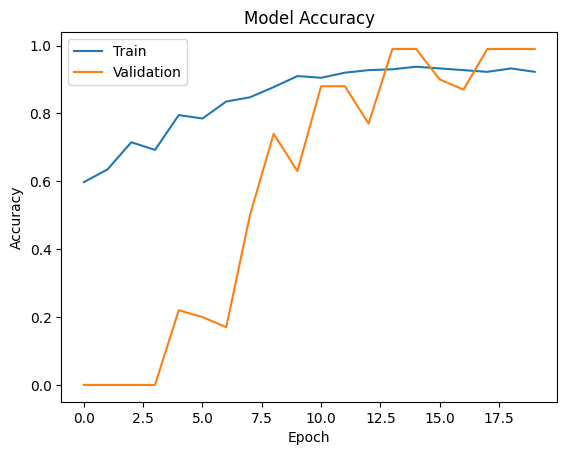

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GRU, Dense, Input, GlobalAveragePooling2D, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define paths to the folders
real_videos_path = "test-real250"
deepfake_videos_path = 'test-fake250'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels = np.array(labels)
# Create a DataFrame
data = pd.DataFrame({'file_name': file_names, 'label': labels})

# Save to a CSV file
data.to_csv('video_labels.csv', index=False)

# Frame extraction
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

def extract_frames(video_path, num_frames):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames
    
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    for frame_counter in range(num_frames):
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        success, frame = video_reader.read()
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frames.append(resized_frame)
    
    video_reader.release()
    return np.array(frames)

def extract_features(frames, xception_model):
    return xception_model.predict(frames)

def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.trainable = False
    return model

def create_model(sequence_length, feature_size):
    video_input = Input(shape=(sequence_length, feature_size))
    
    # Replace LSTM with GRU
    x = Bidirectional(GRU(128, return_sequences=True))(video_input)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=False)(x)
    
    # Add Dense layers for classification
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def main(video_paths, labels, num_frames=10, model_path='gru_model.keras'):
    xception_model = load_xception_model()
    count = 0
    features = []
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        count += 1
        print(count)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)
    
    features = np.array(features)
    labels = np.array(labels)
    
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max', verbose=2
    )
    
    hist = model.fit(features, labels, epochs=20, batch_size=1024, validation_split=0.2, callbacks=[checkpoint])
    return hist

file_address = pd.read_csv("video_labels.csv")
address = file_address.iloc[:, 0]
labels = file_address.iloc[:, 1]
address = np.array(address)
labels = np.array(labels)
print("File loaded")
model_path = 'gru_model.keras'
hist = main(address, labels, 10, model_path)

# Plot training history
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import GRU, Dense, Input, GlobalAveragePooling2D, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define paths to the folders
real_videos_path = "test-real250"
deepfake_videos_path = 'test-fake300'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels = np.array(labels)
# Create a DataFrame
data = pd.DataFrame({'file_name': file_names, 'label': labels})

# Save to a CSV file
data.to_csv('video_labels.csv', index=False)

In [ ]:
# import numpy as np
# import cv2
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.applications.xception import Xception, preprocess_input
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, GRU, Dropout, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint
# from transformers import ViTFeatureExtractor, ViTModel
# import torch

# Frame extraction parameters
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

# Function to detect and crop faces
def crop_faces(frame, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face, target_size)
        return face_resized
    
    return cv2.resize(frame, target_size)

# Function to extract frames from a video
def extract_frames(video_path, num_frames):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames
    
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    for frame_counter in range(num_frames):
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        success, frame = video_reader.read()
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        
        cropped_frame = crop_faces(frame)
        frames.append(cropped_frame)
    
    video_reader.release()
    return np.array(frames)

# Load the Xception model for feature extraction
def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    xception_output = base_model.output
    xception_output = tf.keras.layers.GlobalAveragePooling2D()(xception_output)
    model = Model(inputs=base_model.input, outputs=xception_output)
    return model

# Load the ViT model and feature extractor
# def load_vit_model():
#     feature_extractor = ViTFeatureExtractor()
#     vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#     vit_model.eval()

#     def extract_vit_features(images):
#         inputs = feature_extractor(images=images, return_tensors="pt")
#         with torch.no_grad():
#             outputs = vit_model(**inputs)
#         return outputs.last_hidden_state.mean(dim=1).numpy()

#     return extract_vit_features

# Extract features from frames using Xception and ViT
# def extract_features(frames, xception_model, extract_vit_features):
#     frames_resized = preprocess_input(frames)
#     xception_features = xception_model.predict(frames_resized)
    
#     frames_vit = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]
#     vit_features = extract_vit_features(frames_vit)
    
#     return np.concatenate((xception_features, vit_features), axis=-1)

def extract_features(frames, xception_model):
    return xception_model.predict(frames)

# Model definition
def create_model(sequence_length, feature_size):
    video_input = Input(shape=(sequence_length, feature_size))
    
    x = Bidirectional(GRU(512, return_sequences=True))(video_input)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=False)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Main training loop
def main(video_paths, labels, num_frames=10, model_path='gru_model.keras'):
    xception_model = load_xception_model()
    count = 0
    features = []
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        count += 1
        print(count)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)
    
    features = np.array(features)
    labels = np.array(labels)
    
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max', verbose=2
    )
    
    hist = model.fit(features, labels, epochs=20, batch_size=1024, validation_split=0.2, callbacks=[checkpoint])
    return hist

file_address = pd.read_csv("video_labels.csv")
address = file_address.iloc[:, 0]
labels = file_address.iloc[:, 1]
address = np.array(address)
labels = np.array(labels)
print("File loaded")
model_path = 'gru_model.keras'
hist = main(address, labels, 10, model_path)

# Plot training history
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

File loaded
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
2
